# ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

Реализовать обучение модели линейной регрессии методом градиентного спуска.<br />

В качестве подводящего упражнения в этом задании предлагается реализовать функции потерь и саму модель линейной регрессии в манере, схожей с построением модулей фреймворка pytorch (см. пояснения в шаблонах кода)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки, формулировка меры качества модели;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости);
- оценка параметров модели линейной регрессии (обучение модели) методом градиентного спуска;
- оценка качества модели на валидационной выборке.

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка модели линейной регрессии;
- формулировка функции ошибки;
- формулировка метрики (метрик);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределение признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.

#### Выводы (в форме текста!)
- вывод о том, насколько модель подходит для описания данных
- вывод о достаточности или избыточности данных для оценки параметров модели
- вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Примечания:<br />
Допустимо порождение признаков (полиномиальных, экспоненциальных, логарифмических, etc.)<br />
Реализация линейной регрессии может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.<br />
Из готовых реализаций (напр., из пакета scikit-learn) в этом задании допускается использовать только порождение полиномиальных признаков `PolynomialFeatures`.

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

### Примечание на предмет реализации градиента функции потерь

Нелишним будет вспомнить способ вычисления градиента сложной функции. Здесь функция ошибки (обозначено как $\mathscr{L}$) представлена как сложная функция $\mathscr{L}\left( G\left( \theta \right) \right)$. Для простоты приведена сразу матричная запись.

$$
\nabla_{\theta}{\mathscr{L}} = \nabla_{\theta}{G}\cdot\left(\nabla_{G}{\mathscr{L}}\right)
$$

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

Например, в случае функции потерь MSE это может выглядеть следующим образом:

$$
\nabla_{\theta}{\mathscr{L}} = X^T\cdot2\left(X\theta - Y\right)
$$


При этом логически имеет смысл реализовать компоненту градиента, относящуюся собственно к функции потерь $\nabla_{G}{\mathscr{L}}$ - в коде класса функции потерь, а компоненту, относящуюся к модели $\nabla_{\theta}{G}$ - в коде модели.

Именно поэтому классы `loss` и `linear_regression` в предложенном шаблоне реализованы наследующими `Differentiable` - для общности восприятия этих модулей как дифференцируемых по своим аргументам.

# Решение (Текстовое описание, код и визуализация)

Сформулируем задачу: перед нами стоит задача регрессии, для ее решения мы будем использовать линейную модель, то есть линейную регрессию. В качестве признаков нам передана матрица Xtr, столбцами которой являются признаки, а строками объекты. Про сами признаки мы пока что ничего не знаем, далее взглянем на графики. В качестве функции ошибки мы возьмем `MSE`. В качестве меры качества модели я выбрал `explained_variance_score` из `sklearn.metrics` и значение `loss_value`.

In [2]:
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.metrics import explained_variance_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

Реализуем классы `loss` и `linear_regression` наследующими `Differentiable`.

In [5]:
class Differentiable:
    def __init__(self):
        pass

    def forward(self, **kwargs):
        raise NotImplementedError()

    def backward(self, **kwargs):
        raise NotImplementedError()

In [6]:
class loss(Differentiable):
    def __init__(self):
        super(loss, self).__init__()

    def forward(self, y_pred, y_true):
        loss_value = np.sum((y_pred - y_true)**2 / len(y_pred))
        return loss_value

    def backward(self, y_pred, y_true):
        partial_grad = 2 * (y_pred - y_true) / len(y_pred)
        return partial_grad

In [7]:
class linear_regression(Differentiable):
    def __init__(self):
        super(linear_regression, self).__init__()
        self.theta = None

    def __call__(self, X):
        return self.forward(X)

    def backward(self, X):
        partial_grad = X.T

        return partial_grad

    def forward(self, X):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"

        k = X.shape[1]

        if (self.theta is None):
            np.random.seed(42)
            self.theta = np.random.rand(k, 1)

        y_pred = X @ self.theta
        return y_pred

    def get_weights(self):
        return self.theta

В функции `train_loop` наша модель будет обучаться методом градиентного спуска. В качестве параметров мы передадим ей тренировочную выборку - `X_train` и `y_train`, о разделении будет написано ниже. Также мы передадим нашу `lr_model` - объект класса `linear_regression` и функцию потерь `loss_fn` - обьект класса `loss`.

In [8]:
def train_loop(X, y, model, loss_fn, epochs=100):
    loss_history = []
    scores = []
    pbar = tqdm(total=epochs)
    lr = 0.1
    for epoch in range(epochs):
        y_pred = model(X)
        loss_value = loss_fn.forward(y_pred, y)
        grad = model.backward(X) @ loss_fn.backward(y_pred, y)
        score = explained_variance_score(y, y_pred)
        model.theta -= lr * grad
        
        loss_history.append(loss_value)
        scores.append(score)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value})
    pbar.close()

    return (loss_history, scores)

Подгрузим наши данные и отнормируем признаки с помощью `StandardScaler()`, которое из каждого элемента нашей матрицы вычтет среднее значение и поделит на стандартное отклонение. 

In [9]:
Xtr = np.load('./X_train.npy')
ytr = np.load('./y_train.npy')
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr)

Исследуем наши данные на предмет скоррелированности. Видим, что столбцы 0 и 1 линейно зависимые, поэтому можем выкинуть любой из них. Для определенности выкинем первый.

In [10]:
print(np.corrcoef([Xtr[:, 0], Xtr[:, 1], Xtr[:, 2],
                   Xtr[:, 3]])) 
Xtr = Xtr[:, [0, 2, 3]]

[[1.         0.99930832 0.00924955 0.88100664]
 [0.99930832 1.         0.0096915  0.88030952]
 [0.00924955 0.0096915  1.         0.01899396]
 [0.88100664 0.88030952 0.01899396 1.        ]]


Добавим к нашей матрице признаков единичнный столбец (фиктивный признак) для того, чтобы в уравнении появился свободный член - `bias`. Затем разделим наши данные на обучающую выборку и тестовую.

In [11]:
b = np.ones(Xtr.shape[0])
Xtr = np.column_stack((Xtr, b[:]))
X_train, X_test, y_train, y_test = train_test_split(Xtr,
                                                    ytr,
                                                    test_size=0.8,
                                                    random_state=42)

Построим графики зависимостей признаков друг от друга, а также покажем их зависимости от значения целевой переменной. 

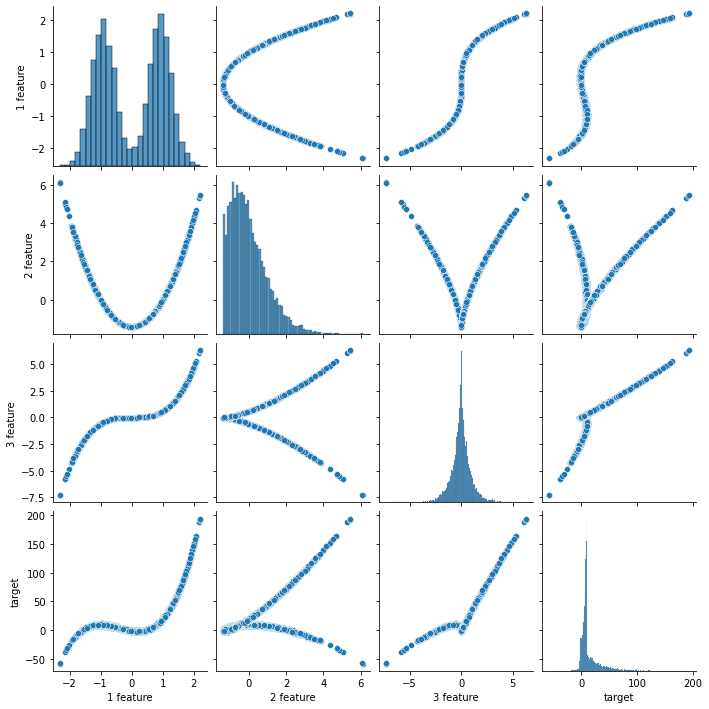

In [12]:
df = pd.DataFrame(Xtr)
df.drop(columns=3, inplace=True)
df['target'] = ytr
df.rename(columns={
    0: "1 feature",
    1: "2 feature",
    2: "3 feature"
},
          inplace=True)
sns.pairplot(df)

In [13]:
# Обучим нашу модель.
obj_fn = loss()
lr_model = linear_regression()
loss_history, scores = train_loop(X_train, y_train, lr_model, obj_fn, epochs=300)

Оценим качество нашей модели с помощью explained_variance_score. score получился близким к единице, что свидетельстует о хорошей работе нашей модели на этих данных, также об этом свитедельствуют показания loss функции, которые с ростом эпохи не возрастают.

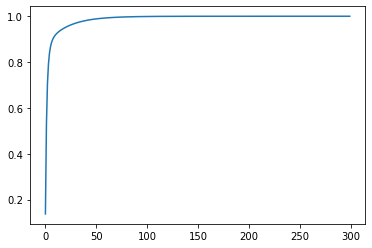

In [14]:
# График зависимости score от количества эпох.
plt.plot(scores)

In [15]:
w = lr_model.get_weights()
y_pred = X_test @ w
explained_variance_score(y_test, y_pred)

0.9985011648883472

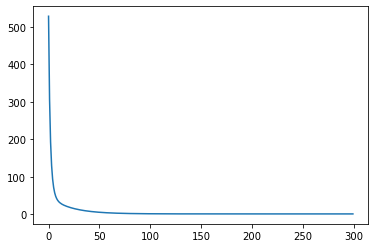

In [16]:
# График зависимости loss_value от количества эпох.
plt.plot(loss_history)

Также покажем на графике собственно саму апроксимацию.

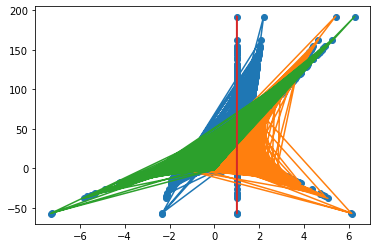

In [21]:
plt.scatter(X_test, y_test * np.ones(4))
plt.plot(X_test, y_pred)

# Выводы

## Вывод о том, насколько модель подходит для описания данных

Из графиков и оценок  качества моделей на валидационной выборке мы можем сделать вывод, что наша модель очень хорошо подходит для описания предоставленных данных.

## Вывод о достаточности или избыточности данных для оценки параметров модели

 Данных оказалось даже больше, чем нужно (0 и 1 столбцы оказались линейно зависимыми). После выкидывания 1 столбца данных оказалось достаточно для оценки параметров модели.

## Вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Явления недообучения и переобучения не наблюдаются.